Mark Oulitin 208283291
Itay Cohen 211896261

In [82]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
import tensorflow.keras.utils
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from tensorflow.keras.models import Sequential
import seaborn as sns
from bs4 import BeautifulSoup
import plotly.express as px

In [69]:
loans = pd.read_csv('input/should-this-loan-be-approved-or-denied/SBAnational.csv')
loans.head()

c:\users\lenovo\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3172: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [70]:
loans.shape

(899164, 27)

Data Understanding

In [71]:
loans.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

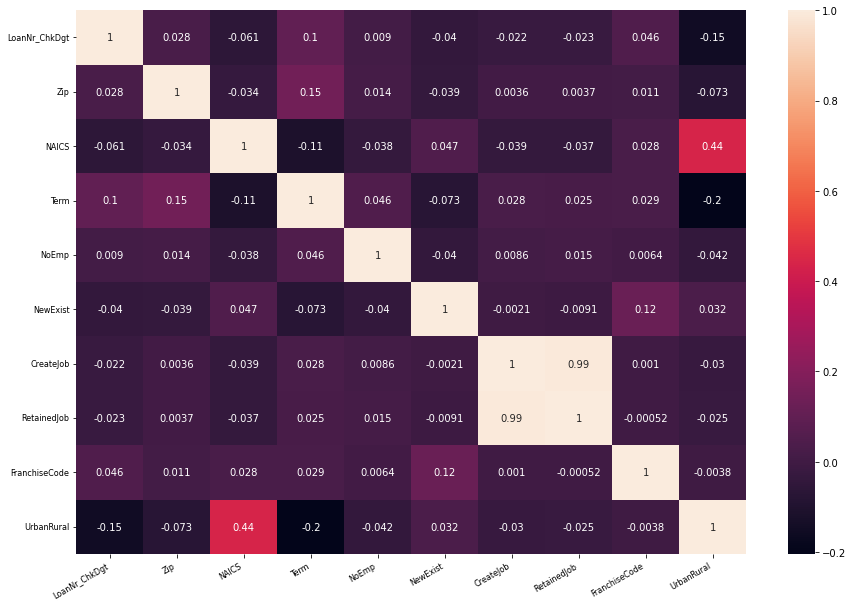

In [72]:
cor_fig, cor_ax = plt.subplots(figsize=(15, 10))
corr_matrix = loans.corr()
cor_ax = sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=30, horizontalalignment='right', fontsize=8)
plt.yticks(fontsize=8)

plt.show()

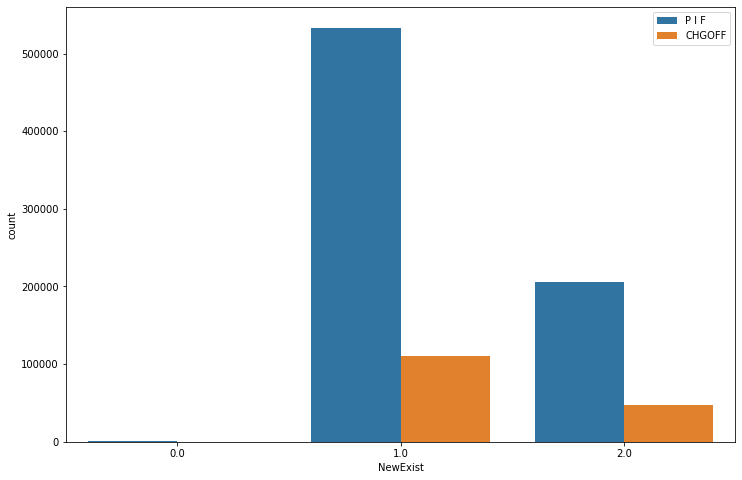

In [73]:
plt.figure(figsize=(12,8))
sns.countplot(x="NewExist", hue="MIS_Status", data=loans)
plt.legend()
plt.show()

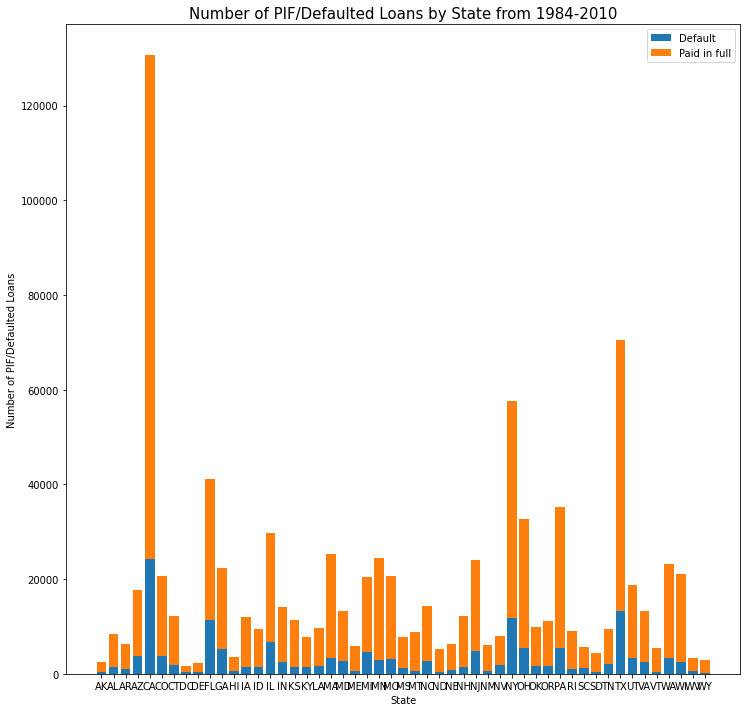

In [80]:
fig3 = plt.figure(figsize=(20, 10))

ax1 = fig3.add_subplot(1, 2, 1)

df = loans

df['Default'] = np.where(df['MIS_Status'] == 'P I F', 0, 1)
df['Default'].value_counts()

data = df.groupby(['State', 'Default'])['State'].count().unstack('Default')
data.fillna(0)

ax1.bar(data.index, data[1], label='Default')
ax1.bar(data.index, data[0], bottom=data[1], label='Paid in full')

ax1.set_title('Number of PIF/Defaulted Loans by State from 1984-2010', fontsize=15)
ax1.set_xlabel('State')
ax1.set_ylabel('Number of PIF/Defaulted Loans')
ax1.legend()

plt.tight_layout()
plt.show()

In [83]:
fig = px.choropleth(loans,
                    locations='State',
                    color='MIS_Status',
                    color_continuous_scale='spectral_r',
                    hover_name='State',
                    locationmode='USA-states',
                    labels={'Default rate':'MIS_Status'},
                    scope='usa')
fig.show()

KeyError: (nan, '', '', '')

In [ ]:
loans.columns

Data Preparation

In [ ]:
# we want to make a binary value stating if the loan was defaulted or not
loans['Defaulted'] = [1 if app == 'CHGOFF' else 0 for app in loans.MIS_Status.values]
loans = loans.drop(columns=['MIS_Status'])

# we only take the loans created before 2007
loans['ApprovalFY'] = loans['ApprovalFY'].replace({'A':'','B':''}, regex = True).astype(int)
loans.drop(loans[loans['ApprovalFY']>2007].index, axis = 0, inplace = True)

loans = loans.drop(columns=['ApprovalFY','ApprovalDate','DisbursementDate','ChgOffDate','LoanNr_ChkDgt','Name','Zip', 'City', 'Bank'])

In [ ]:
loans.head()

In [ ]:
loans.shape

In [ ]:
def amount_to_float(number):
    num = number.replace("$", "")
    num = num.replace(",","")
    num = num.replace(" ","")
    return float(num)

#instead of dealing with money as a string we will deal with it as a number
loans['BalanceGross'] = loans['BalanceGross'].apply(lambda x: amount_to_float(x))
loans['DisbursementGross'] = loans['DisbursementGross'].apply(lambda x: amount_to_float(x))
loans['ChgOffPrinGr'] = loans['ChgOffPrinGr'].apply(lambda x: amount_to_float(x))
loans['GrAppv'] = loans['GrAppv'].apply(lambda x: amount_to_float(x))
loans['SBA_Appv'] = loans['SBA_Appv'].apply(lambda x: amount_to_float(x))

In [ ]:
# we replace it to be a binary where 1 to be a new business and 0 an old business
loans['NewExist'] = loans['NewExist'].replace(1,0)
loans['NewExist'] = loans['NewExist'].replace(2,1)

In [ ]:
# we replace them both to be binary instead of Y and N
loans['LowDoc'] = loans['LowDoc'].replace({'Y':'1', 'N':'0'}, regex=True)
valid = ['1', '0']
loans = loans.loc[loans['LowDoc'].isin(valid)]
loans['LowDoc'] = loans['LowDoc'].astype(int)
loans['RevLineCr'] = loans['RevLineCr'].replace({'Y':'1', 'N':'0'}, regex=True)
loans = loans.loc[loans['RevLineCr'].isin(valid)]
loans['RevLineCr'] = loans['RevLineCr'].astype(int)

In [ ]:
# we make franchise a binary value where 1 is true and 0 is false
loans['FranchiseCode'] = loans['FranchiseCode'].replace(1,0)
loans['FranchiseCode'] = np.where((loans.FranchiseCode != 0),1,loans.FranchiseCode)
loans.rename(columns={"FranchiseCode":"Franchise"},inplace=True)

In [ ]:
loans.shape

In [ ]:
loans = pd.get_dummies(loans,columns=['BankState','State'],prefix=['BankState','State'])

In [ ]:
#only take the first 2 digits from the NAICS values
def first_n_digits(number, n):
    return int(str(number)[:n])
loans['NAICS'] = loans['NAICS'].apply(lambda x: first_n_digits(x,2))

In [ ]:
loans.head()

In [ ]:
loans['NAICS'].unique()

In [ ]:
loans.columns

In [ ]:
loans.dtypes

Modeling

In [ ]:
y = loans['Defaulted']
X = loans.drop(columns=['Defaulted'])
y_backup = y
X = X.to_numpy()
y = pd.get_dummies(y)
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [ ]:
# the ration between the 0s and 1s is about 1:5
y_backup.value_counts()

In [ ]:
n_inputs = X.shape[1]
e = Sequential()
e.add(Dense(100, activation= 'tanh', input_shape = [n_inputs]))
e.add(Dense(50, activation= 'tanh'))
e.add(Dense(16, activation= 'tanh'))
e.add(Dense(2, activation= 'tanh'))

In [ ]:
d = Sequential()
d.add(Dense(16, activation= 'tanh', input_shape = [2]))
d.add(Dense(50, activation= 'tanh'))
d.add(Dense(100, activation= 'tanh'))
d.add(Dense(n_inputs, activation= 'tanh'))


In [ ]:
# define auto-encoder model
autoencoder = Sequential([e, d])

In [ ]:
# compile auto-encoder model
autoencoder.compile(optimizer='adam', loss='mse')

n_epochs = 10
batch_size = 256

X_train = np.asarray(X_train).astype('float32')
fit_time = autoencoder.fit(X_train, X_train, epochs=n_epochs, batch_size=batch_size,
                     )

In [ ]:
#plot_confusion_matrix(model, X_test, y_test, normalize = 'true')
Xpred = autoencoder.predict(X_train, verbose=1)

In [ ]:
enc_X_train = e.predict(X_train)
enc_X_test = e.predict(X_test)

In [ ]:
clf = DecisionTreeClassifier()

y_train_labels = np.argmax(y_train, axis = 1)
y_test_labels = np.argmax(y_test, axis = 1)

In [ ]:
clf.fit(X_train, y_train_labels)

Evaluation

In [ ]:
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test_labels, y_pred)
print(cm)
print(classification_report(y_test_labels, y_pred))

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(clf,X_test,y_test_labels, normalize = 'true')

In [ ]:
TN = cm[0][0]
FN = cm[1][0]
TP = cm[1][1]
FP = cm[0][1]

WACC = 0.25*(TP/(TP+FN))+0.75*(TN/(TN+FP))
print(WACC)